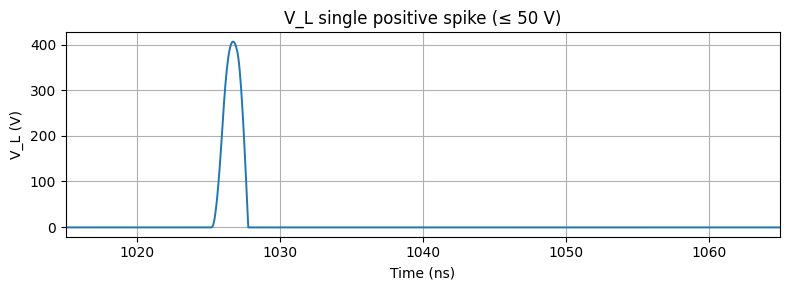

In [2]:
# vl_pulse_fig6_clamped_50V.py
# Macro model with negative clamp diode so V_L is a single positive spike
# Peak limited to ~50 V

from PySpice.Spice.Netlist import Circuit
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Parameters
# -----------------------
A1 = 55.0
A2 = 150.0
T1 = 1.0e-6
T2 = 0.5e-6
TR = 5e-9
PER = T1 + T2 + 0.5e-6

L_val = 0.1e-6       # H
Ceff  = 5e-12        # F
RL    = 300.0        # ohm
Rs    = 50.0         # ohm

tsd_est  = 25e-9
t_flip   = T1
t_inject = t_flip + tsd_est

# >>> AMPLITUDE CONTROL <<<
Ipeak     = 5.0      # A  <<< scaled for ~50 V peak
inj_width = 1.0e-9   # s

sim_end   = PER
step_time = 0.05e-9  # 50 ps

# -----------------------
# Build circuit
# -----------------------
circuit = Circuit('VL_pulse_fig6_clamped_50V')

# Bipolar Vin (timing reference)
circuit.V(
    'in', 'vin', circuit.gnd,
    f'PULSE({-A1} {A2} 0 {TR} {TR} {T1} {PER})'
)

# L + Rs
circuit.L('L1', 'vin', 'nL', L_val)
circuit.R('RS', 'nL', 'nx', Rs)

# Load and effective capacitance
circuit.R('RL', 'nx', circuit.gnd, RL)
circuit.C('CEFF', 'nx', circuit.gnd, Ceff)

# Injected reverse current (snap-off trigger)
Iexpr = f'PULSE(0 {Ipeak} {t_inject} 1n 1n {inj_width} {sim_end})'
circuit.I('inj', circuit.gnd, 'nx', Iexpr)

# -----------------------
# Negative clamp diode
# Anode = GND, Cathode = nx
# -----------------------
circuit.model('Dclamp', 'D', Is=1e-15, N=1)
circuit.D('NCLAMP', circuit.gnd, 'nx', model='Dclamp')

# -----------------------
# Simulate
# -----------------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=step_time, end_time=sim_end)

time = np.array(analysis.time)
vL = np.array(analysis.nodes['nx'])

# -----------------------
# Plot (ns-scale spike only)
# -----------------------
plt.figure(figsize=(8, 3))
plt.plot(time * 1e9, vL, linewidth=1.4)
plt.title('V_L single positive spike (≤ 50 V)')
plt.xlabel('Time (ns)')
plt.ylabel('V_L (V)')
plt.grid(True)
plt.xlim((t_inject - 10e-9) * 1e9, (t_inject + 40e-9) * 1e9)
plt.tight_layout()
plt.show()
